In [1]:
from importlib import reload
import BacktestEngine.backtest as backtest
import BacktestEngine.order_book as order_book
import scipy.odr as odr

In [79]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import yfinance as yf
import pickle
import os
import math
from ReferentialData.polygonData import PolygonAPI
from DataAnalysis import DataExtensions
from Filtering.KalmanFilter import KalmanFilter

In [3]:
## End Date
end_dt = "2025-01-01"
## Start date
start_dt = "2020-01-01"
# Loading "pairs trade" buckets
DIR = r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache'
COR_DIR = r'\Users\raymo\OneDrive\Desktop\Playground\Financial-Modelling-Playground\Quant_Trading\Clustering'
with open(os.path.join(COR_DIR, "correlation_buckets_no_shorts.pkl"), "rb") as file:
    BUCKETS = pickle.load(file)

In [4]:
# Concatenating dictionary value lists
UNIVERSE=[]
for i in list(BUCKETS.values()):
    UNIVERSE.extend(i)

In [5]:
colnames = ["Close", "Volume"]
DataLoader = PolygonAPI()
MID_LOADED = False
HIGH_LOADED = False
if not MID_LOADED:
    mid_df = {}
if not HIGH_LOADED:
    high_df = {}
### loading in low frequency data
if len(mid_df) == 0:
    mid_df = DataLoader.getPrices(UNIVERSE, timespan= "day", from_ = start_dt, 
                                    to_=end_dt,
                                  logDir=DIR, _parallel=True)
    MID_LOADED = True

### loading in high frequency data
if len(high_df) == 0:
    high_df = DataLoader.getPrices(UNIVERSE,from_ = start_dt, 
                                    to_=end_dt, timespan="minute", logDir=DIR, _parallel=True, override=False)
    HIGH_LOADED = True


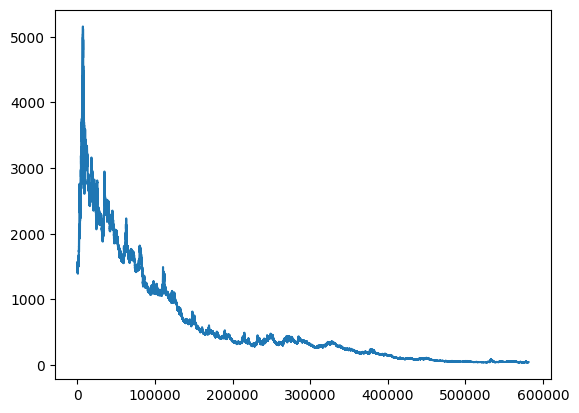

In [6]:
# plt.plot(high_df[0])
plt.plot(high_df[0]['VIXY']['close'])

## Analysis of first correlation bucket

In [7]:
BUCKETS

{'AOA': ['AOA', 'SPXS', 'SPXU', 'SH', 'SDS'],
 'AIQ': ['AIQ', 'SQQQ', 'QID', 'PSQ'],
 'AGQ': ['AGQ', 'ZSL'],
 'AGG': ['AGG', 'TTT', 'TYO', 'TMV', 'TBT', 'TBX', 'PST'],
 'ACWX': ['ACWX', 'EPV', 'EFZ', 'EFU'],
 'ACWI': ['ACWI', 'SPXU', 'SPXS', 'SH', 'SDS'],
 'AAXJ': ['AAXJ', 'EUM', 'EEV'],
 'ZSL': ['ZSL', 'SLV', 'SIVR', 'GLTR'],
 'ZROZ': ['ZROZ', 'TMV', 'TTT', 'TBT'],
 'XBI': ['XBI', 'LABD'],
 'YCL': ['YCL', 'YCS'],
 'YINN': ['YINN', 'YANG', 'YXI', 'FXP'],
 'YCS': ['YCS', 'FXY'],
 'YXI': ['YXI', 'XPP', 'KWEB', 'GXC', 'FXI', 'CWEB', 'BKF'],
 'YANG': ['YANG', 'XPP', 'KWEB', 'GXC', 'FXI', 'CWEB', 'BKF'],
 'XT': ['XT', 'HIBS'],
 'XTR': ['XTR', 'SQQQ', 'SPXS', 'SPXU', 'SH', 'SDS', 'QID', 'PSQ'],
 'XSOE': ['XSOE', 'EUM', 'EEV'],
 'XSVM': ['XSVM', 'TWM', 'TZA', 'SRTY', 'SMDD', 'SDD', 'RWM'],
 'XSMO': ['XSMO', 'TZA', 'TWM', 'SRTY', 'SMDD', 'SDD', 'RWM'],
 'XPP': ['XPP', 'FXP'],
 'XNTK': ['XNTK', 'SQQQ', 'SOXS', 'QID', 'PSQ'],
 'XMLV': ['XMLV', 'SMDD'],
 'XMMO': ['XMMO', 'SMDD'],
 'XLG': ['XLG', 

In [8]:
# bucket_mask = lambda price_data: price_data[0] in BUCKETS[list(BUCKETS.keys())[1]]
bucket_mask = lambda price_data: price_data[0] in BUCKETS['VIXY']
hf_bucket = dict(filter(bucket_mask, high_df[0].items()))
mf_bucket = dict(filter(bucket_mask, mid_df[0].items()))

### Need to find weighting for positions in portfolio

In [9]:
beta = pd.read_csv(r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache\Beta_Callibration\^FTW5000_beta.csv')
beta = beta.loc[:, ~beta.columns.str.contains('^Unnamed')]
beta['Beta'] = [float(x.split(",")[0][1:]) for x in beta['Beta']]
beta = beta[beta.apply(bucket_mask, axis=1)]
beta = beta.set_index("Ticker")
beta = beta.to_dict()['Beta']

import yfinance as yf

bm_ticker = "^FTW5000"
## extract benchmark data 
yf_res = yf.Ticker(bm_ticker)
# get historical market data
# hist = mid_df[0]['ACWI']
hist = yf_res.history(interval="1D", period='2y').reset_index().rename(columns={'Close':bm_ticker,
                'Date':'timestamp'}).set_index('timestamp')
hist = hist.tz_localize(None)
bm_data = hist[[bm_ticker]]
bm_data

# ### save this since yahoo finance is really unstable...
# bm_data.to_csv(r'C:\Users\raymo\OneDrive\Desktop\Playground\Financial-Modelling-Playground\Quant_Trading\BetaModels\FTW5000.csv')
# bm_data = pd.read_csv(r'C:\Users\raymo\OneDrive\Desktop\Playground\Financial-Modelling-Playground\Quant_Trading\BetaModels\FTW5000.csv')


C:\Users\raymo\AppData\Local\Temp\ipykernel_40360\1586568570.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bucket_mask = lambda price_data: price_data[0] in BUCKETS['VIXY']


,^FTW5000
timestamp,
2023-04-18,41059.039062
2023-04-19,41064.578125
2023-04-20,40808.878906
2023-04-21,40845.910156
2023-04-24,40855.570312
...,...
2025-04-11,53283.019531
2025-04-14,53722.269531
2025-04-15,53652.519531


In [10]:
corr = pd.read_csv(r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache\Beta_Callibration\pairwise_corr.csv')
corr = corr.loc[:, ~corr.columns.str.contains('^Unnamed')]
bucket_corr_mask = lambda price_data: len(set(price_data[0].split(',')).intersection(set(BUCKETS[list(BUCKETS.keys())[0]])))==2
corr = corr[corr.apply(bucket_corr_mask, axis=1)]
corr = corr.sort_values(by="Cross Correlation")
corr

C:\Users\raymo\AppData\Local\Temp\ipykernel_40360\4063414317.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bucket_corr_mask = lambda price_data: len(set(price_data[0].split(',')).intersection(set(BUCKETS[list(BUCKETS.keys())[0]])))==2


,Ticker Pair,Cross Correlation
7134,"AOA,SDS",-0.950992
7083,"AOA,SPXU",-0.948960
7125,"AOA,SH",-0.948941
7089,"AOA,SPXS",-0.948182
129160,"SPXS,SH",0.993566
128571,"SPXU,SH",0.994723
152083,"SH,SDS",0.997474
129169,"SPXS,SDS",0.997839
128540,"SPXU,SPXS",0.998401
128578,"SPXU,SDS",0.998524


In [11]:
hf_df = pd.DataFrame()
mf_df = pd.DataFrame()
for ticker in hf_bucket:
    if len(hf_df) == 0:
        temp = hf_bucket[ticker].rename(columns={'close':ticker})[['timestamp',ticker]]
        temp['timestamp'] = pd.to_datetime(temp['timestamp'], unit='ms')
        hf_df = temp.set_index('timestamp')
    else:
        temp = hf_bucket[ticker].rename(columns={'close':ticker})[['timestamp',ticker]]
        temp['timestamp'] = pd.to_datetime(temp['timestamp'], unit='ms')
        hf_df = hf_df.join(temp.set_index('timestamp'),
                       how = 'left')
hf_df = hf_df.fillna(method='ffill')
hf_df = hf_df.dropna() ## removes dates where not all components are present

for ticker in mf_bucket:
    if len(mf_df) == 0:
        temp = mf_bucket[ticker].rename(columns={'close':ticker})[['timestamp',ticker]]
        temp['timestamp'] = pd.to_datetime(temp['timestamp'], unit='ms')
        mf_df = temp.set_index('timestamp')
    else:
        temp = mf_bucket[ticker].rename(columns={'close':ticker})[['timestamp',ticker]]
        temp['timestamp'] = pd.to_datetime(temp['timestamp'], unit='ms')
        mf_df = mf_df.join(temp.set_index('timestamp'),
                       how = 'left')
mf_df = mf_df.fillna(method='ffill')
mf_df = mf_df.dropna() ## removes dates where not all components are present
mf_df

C:\Users\raymo\AppData\Local\Temp\ipykernel_40360\3707829485.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hf_df = hf_df.fillna(method='ffill')
C:\Users\raymo\AppData\Local\Temp\ipykernel_40360\3707829485.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mf_df = mf_df.fillna(method='ffill')


,SVXY,SVIX,VIXY
timestamp,,,
2022-03-30 04:00:00,28.010,14.79,315.80
2022-03-31 04:00:00,27.280,14.04,331.40
2022-04-01 04:00:00,27.825,14.61,320.00
2022-04-04 04:00:00,28.535,15.33,302.80
2022-04-05 04:00:00,27.325,14.01,328.40
...,...,...,...
2025-02-19 05:00:00,52.320,27.00,40.50
2025-02-20 05:00:00,52.240,26.91,40.73
2025-02-21 05:00:00,50.380,25.07,43.56


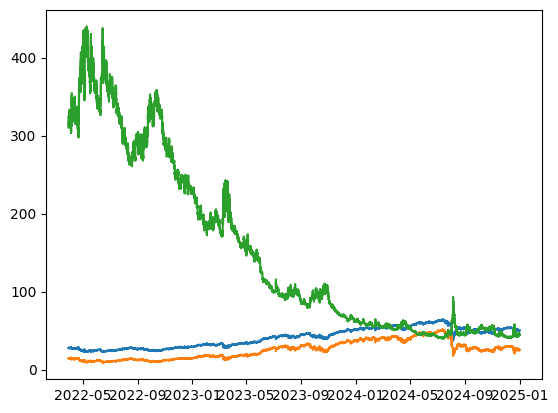

In [12]:
plt.plot(hf_df)

In [13]:
import datetime
from importlib import reload
import OptimizationEngine.mipEngine
reload(OptimizationEngine.mipEngine)

daily_dt = 10e3*60*60*24
min_dt = 10e3*60
dt_ratio = daily_dt / min_dt 

import time
def datetime_to_ms_epoch(dt):
    microseconds = time.mktime(dt.timetuple()) * 1000000 + dt.microsecond
    return int(round(microseconds / float(1000)))

def get_unixtime(dt64):
    return dt64.astype('datetime64[s]').astype('int')

def shift(xs, n):
    if n >= 0:
        return np.concatenate((np.full(n, np.nan), xs[:-n]))
    else:
        return np.concatenate((xs[-n:], np.full(-n, np.nan)))
    
def getTimeDiffs(dt_list: np.array):
    ## case to ms unix tyime
    if type(dt_list[0]) == np.datetime64:
        dt_list = get_unixtime(dt_list)
    shifted_dt = np.roll(dt_list, 1)
    res = dt_list - shifted_dt
    res[0] = 0 ## as this makes no sense
    return res

logReturnTransform = lambda df : np.log(df.loc[:,~df.columns.str.contains('timestamp')]) - np.log(df.loc[:,~df.columns.str.contains('timestamp')].shift(1))
def logRetDtDailyTransform(df):
    return logReturnTransform(df.loc[:,~df.columns.str.contains('timestamp')]).apply(
        lambda col: np.asarray(col) / getTimeDiffs(np.asarray(df.index.values)) *math.sqrt(dt_ratio))

# print('Beta Adjustment on Mid-Frequency is: {0}.'.format(mf_betaAdj))

mf_summary = {}
for data in mf_bucket:
    mu = logReturnTransform(mf_bucket[data].drop('otc',axis=1))['close'].mean()
    std = logReturnTransform(mf_bucket[data].drop('otc',axis=1))['close'].std()
    mu_hf = logRetDtDailyTransform(hf_bucket[data].drop('otc',axis=1))['close'].mean()
    std_hf = logRetDtDailyTransform(hf_bucket[data].drop('otc',axis=1))['close'].std()
    mf_summary[data] = {"Mu": mu, "Sigma":std, "Beta":beta[data],
                        "Mu_Min": mu_hf, "Sigma_Min": std_hf}
mf_summary = pd.DataFrame(mf_summary)

mf_summary

,SVXY,SVIX,VIXY
Mu,0.000527,0.000704,-0.002784
Sigma,0.025188,0.042613,0.046916
Beta,-0.000241,-0.000147,0.000504
Mu_Min,0.000046,0.000075,-0.000226
Sigma_Min,0.046951,0.086763,0.089100


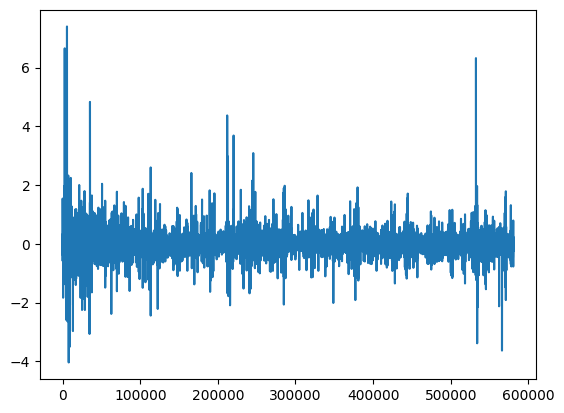

In [14]:
plt.plot(logRetDtDailyTransform(hf_bucket[data].drop('otc',axis=1))['close'])

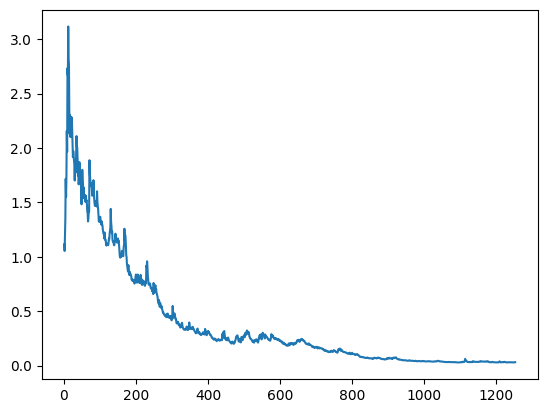

In [15]:
original = np.exp(logReturnTransform(mf_bucket['VIXY'].drop('otc',axis=1))['close'])
plt.plot(original.cumprod())
# plt.plot(mf_bucket['PSQ'].index, mf_bucket['PSQ']['PSQ'])
# mf_bucket['PSQ']

## Running Ordinary Linear Regression for Weighting

In [16]:

hf_df.to_csv(r'C:\Users\raymo\OneDrive\Desktop\test.csv')

In [17]:
import pandas as pd
from numpy import arange
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold#define cross-validation method to evaluate model

def RidgeRegression(X,y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    #define model
    model = RidgeCV(alphas=arange(0, 1, 0.01), 
                    cv=cv, 
                    scoring='neg_mean_absolute_error',
                    fit_intercept=False)

    #fit model
    model.fit(X, y)

    #display lambda that produced the lowest test MSE
    print(model.coef_)

    return model


def ElasticNet(X,y, l1=0.5):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    #define model
    model = ElasticNetCV(alphas=arange(0, 1, 0.01), 
                    cv=cv,
                    fit_intercept=False,
                    positive=True,
                    l1_ratio=l1)

    #fit model
    model.fit(X, y)

    #display lambda that produced the lowest test MSE
    print(model.coef_)

    return model

In [18]:
def tls(X, y):
    """
    Performs Total Least Squares regression.

    Args:
        X (numpy.ndarray): Design matrix (n_samples, n_features)
        y (numpy.ndarray): Target vector (n_samples,)

    Returns:
        numpy.ndarray: Estimated coefficients (n_features,)
    """

    # Construct augmented matrix
    A = np.hstack((X, y.reshape(-1, 1)))

    # Perform SVD
    U, S, V = np.linalg.svd(A)

    # Extract coefficients
    Vxy = V[-1, :-1]
    Vyy = V[-1, -1]

    return -Vxy / Vyy

In [19]:
# Define a function (quadratic in our case)
# to fit the data with.
# odr initially assumes a linear function
def f(B, x):
    return B[0] + np.dot(B[1:], x)  # B[0] is the intercept, B[1:] are the slopes

### log returns of high frequency data frame

# neutralizeBeta = lambda dcol: dcol[ticker] - mf_summary[ticker] for ticker in df)
mf_log = logReturnTransform(mf_df)
mf_log = pd.merge_asof(mf_log.reset_index(), logReturnTransform(bm_data), on = 'timestamp').dropna().set_index('timestamp')
components = list(mf_log.columns.values)
components.remove(bm_ticker)
### remove beta from FTW5000
mf_log[components] = mf_log[components].apply(lambda dcol: dcol - mf_summary.loc['Beta', dcol.name] 
                                                    *mf_log[bm_ticker] , axis = 0)
mf_log.drop(bm_ticker, axis=1, inplace=True) ## remove benchmark data
reference_ticker = 'VIXY' #hf_df.columns[0]
x_temp = mf_log.loc[:, ~mf_log.columns.str.contains(reference_ticker)]
x_temp = -1*x_temp.iloc[1:]


# x1=  np.array(x_temp['SPXS'])
# x2= np.array(x_temp['SPXU'])
# x3 = np.array(x_temp['SH'])
# x4=np.array(x_temp['SDS'])
# x = np.column_stack((x1,x2,x3,x4))
x = np.array(x_temp)
y = np.array(mf_log[reference_ticker].iloc[1:])

#  model fitting.
odr_model = odr.Model(f)
 
# Create a Data object using sample data created.
data = odr.Data(x, y)
 
# # Set ODR with the model and data.
# ordinal_distance_reg = odr.ODR(data, odr_model,
#                                beta0=[0] + [1]*x.shape[1])
 
# # Run the regression.
# out = ordinal_distance_reg.run()
 
# # print the results
# out.pprint()

# ElasticNet(x,y, 0)
coeffs_ = RidgeRegression(x,y).coef_

# # Plot the data and the fit
# plt.scatter(x, y)
# plt.plot(x, out.beta[0] * x + out.beta[1], color='red')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Orthogonal Linear Regression')
# plt.show()

[ 2.62275888 -0.39801015]


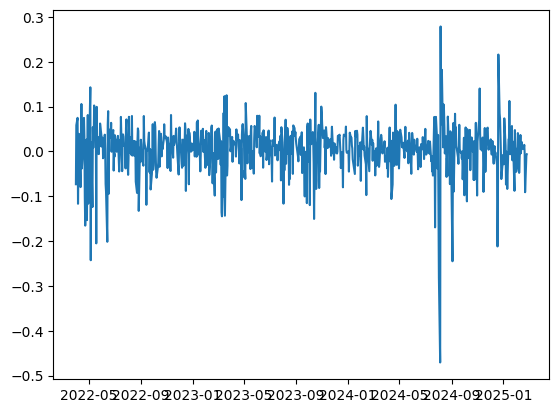

In [20]:
def hurst(ts):
    """Calculates the Hurst Exponent of the time series vector ts"""

    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0] * 2.0

reference_ticker = "VIXY"
elementExp = lambda row, coeffs: np.power(np.array(row), coeffs_)
positive_legs = mf_df.loc[:, ~mf_df.columns.str.contains(reference_ticker)]
signal = positive_legs.apply(lambda dr:elementExp(dr, coeffs_).sum(), axis = 1)
signal = signal.add(-1*mf_df[reference_ticker])
raw = pd.DataFrame(positive_legs.apply(lambda dr:elementExp(dr, coeffs_).sum(), axis = 1)).join(mf_df[reference_ticker])
# print('Hurst: ', hurst(np.array(signal.resample('1D').agg('last').dropna())))
# plt.hist(signal.pct_change(),bins=100)
plt.plot(signal.pct_change())
# plt.scatter(logReturnTransform(positive_legs.apply(lambda dr:elementExp(dr, coeffs_).sum(), axis = 1)),
#             logReturnTransform(hf_df[reference_ticker]))

In [78]:
reload(DataExtensions)
outlier_idxs = DataExtensions.zscoreOutliers(signal.pct_change(), params={'std':6})
## these are looking for stock splits 
win1 = outlier_idxs[0]
hf_df[win1[0] - pd.Timedelta(days=2):win1[1]+ pd.Timedelta(days=2)]

,SVXY,SVIX,VIXY
timestamp,,,
2024-08-05 08:00:00,46.6000,26.56,74.0000
2024-08-05 08:03:00,43.2200,26.56,79.9600
2024-08-05 08:04:00,42.7600,26.70,80.1200
2024-08-05 08:05:00,42.7400,27.14,79.9600
2024-08-05 08:06:00,43.3000,27.14,78.2400
...,...,...,...
2024-08-07 23:55:00,43.2000,21.51,71.0000
2024-08-07 23:56:00,43.1000,21.35,71.0000
2024-08-07 23:57:00,43.1300,21.40,71.0000


In [22]:
# ### find new beta of signal to benchmark
# from BetaModels.BetaCovFactory import BetaCovFactory
# daily_signal = pd.DataFrame(signal.resample('1D').last().dropna(),
#                             columns=['DailySignal'])
# print(daily_signal)
# bm_ticker = "^FTW5000"

# ## extract benchmark data 
# yf_res = yf.Ticker(bm_ticker)
# info = yf_res.info
# # get historical market data
# hist = yf_res.history(interval="1D", period='5y').rename(columns={'Close':bm_ticker})
# hist = hist.tz_localize(None)
# #hist.index = hist.index.normalize()
# bm_data = hist[[bm_ticker]].rename(columns={'Date':'timestamp'})
# bmFactory = BetaCovFactory(logReturnTransform(bm_data)[1:])
# signalBeta = bmFactory.calculateBeta(logReturnTransform(daily_signal)[1:])[0]
# signalBeta

Signal = pd.DataFrame(signal, columns=['Signal'])
# Signal['timestamp'] = [datetime_to_ms_epoch(ts) for ts in Signal['timestamp']]
Signal

,Signal
timestamp,
2022-03-30 04:00:00,5935.597136
2022-03-31 04:00:00,5501.702134
2022-04-01 04:00:00,5823.692814
2022-04-04 04:00:00,6260.580468
2022-04-05 04:00:00,5529.971030
...,...
2025-02-19 05:00:00,32144.588205
2025-02-20 05:00:00,32015.446749
2025-02-21 05:00:00,29104.983007


In [23]:
positive_legs

,SVXY,SVIX
timestamp,,
2022-03-30 04:00:00,28.010,14.79
2022-03-31 04:00:00,27.280,14.04
2022-04-01 04:00:00,27.825,14.61
2022-04-04 04:00:00,28.535,15.33
2022-04-05 04:00:00,27.325,14.01
...,...,...
2025-02-19 05:00:00,52.320,27.00
2025-02-20 05:00:00,52.240,26.91
2025-02-21 05:00:00,50.380,25.07


In [24]:
reference_ticker

'VIXY'

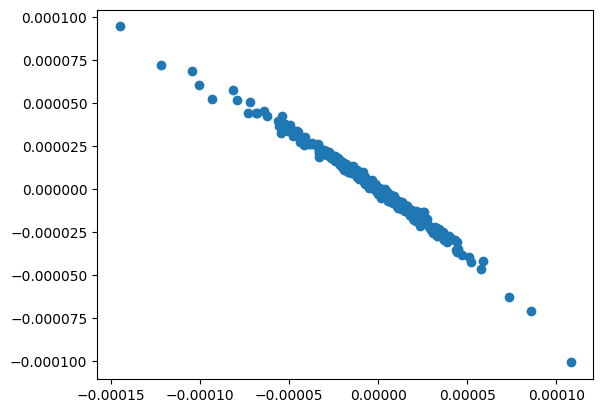

In [25]:
plt.scatter(logRetDtDailyTransform(Signal),
            logRetDtDailyTransform(pd.DataFrame(mf_df[reference_ticker])))

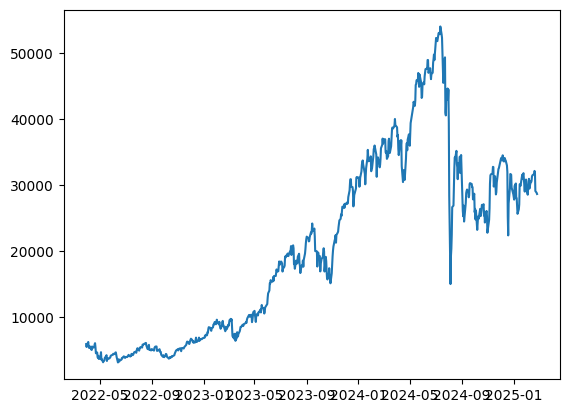

In [26]:
plt.plot(Signal)

Text(0, 0.5, 'Value')

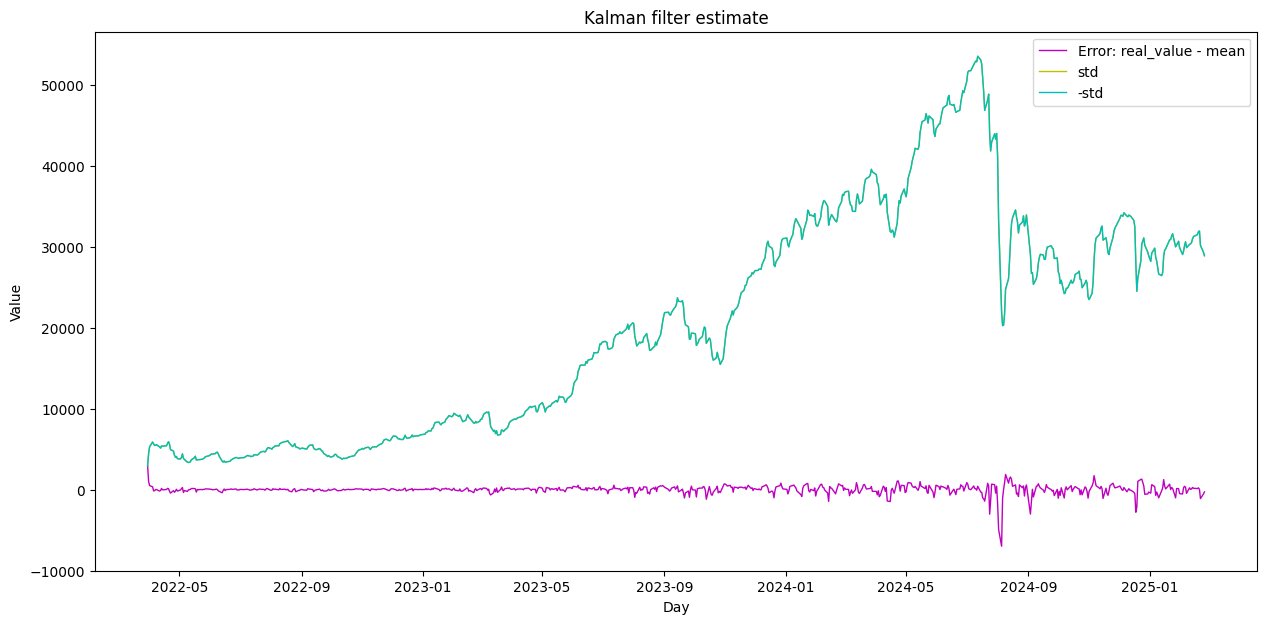

In [27]:
## Filtering
# filter = KalmanFilter(raw)
reload(KalmanFilter)
names = [0, 'VIXY']#['AIQ',0]
means, covs = KalmanFilter.KalmanFilter.UnivariateKF('Signal', Signal, 
                                                     1,
                                                     1)
# Create subplots with shared axes
# fig, axes = plt.subplots(1, 2, sharex=True)
# # Plot data on each subplot
# axes[0].plot(Signal.index, means.squeeze())
# axes[1].plot(Signal.index, covs.squeeze())

mean, std = means.squeeze(), np.std(covs.squeeze())

plt.figure(figsize=(15,7))
plt.plot(Signal.index, Signal['Signal'] - mean, 'm', lw=1)
plt.plot(Signal.index, mean.squeeze() + np.sqrt(covs.squeeze()), 'y', lw=1)
plt.plot(Signal.index, mean.squeeze() - np.sqrt(covs.squeeze()), 'c', lw=1)
plt.title('Kalman filter estimate')
plt.legend(['Error: real_value - mean', 'std', '-std'])
plt.xlabel('Day')
plt.ylabel('Value')

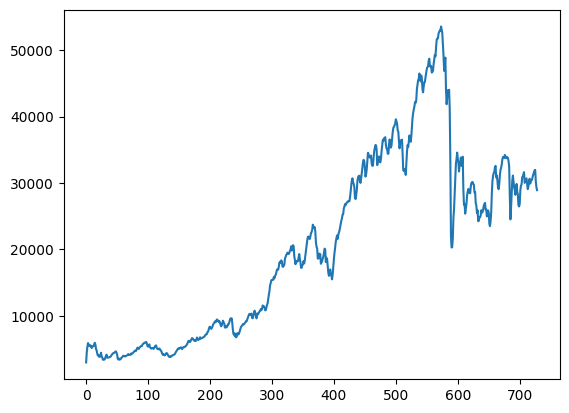

In [28]:
"""
Need to check math on regression on return back to signal level.
logret(Y) = Beta*logret(X) [assume  centered 0]
log(Y) - log(Y') = Beta*(log(X) - log(X'))
log(Y) - log(Y') = log(sum_i x_i^beta_i) - log(sum_i x'_i^beta_i)

"""
state_means, state_covs =means, covs 
plt.plot(state_means)#, state_covs
# DataExtensions.draw_slope_intercept_changes(Signal, state_means)

[ 2968.29856775  4488.3407074   5310.09584984  5897.15987857
  5670.24542165  5475.53344492  5531.42410288  5563.24435179
  5300.99210316  5144.07926915  5414.53439451  5386.91315302
  5439.32495556  5712.56443622  5939.37649219  5638.27972694
  4965.73868319  4783.24728944  4271.26848752  4011.7849649
  4106.13530865  3842.22521498  3795.28095416  3997.39660465
  4439.29930402  3901.35777249  3740.45461958  3399.89551589
  3376.84002705  3384.99317893  3454.39337485  3702.65458582
  3950.41385549  4142.68343743  3676.03170562  3706.27047087
  3708.34520171  3760.46169954  3766.59830584  3845.06689545
  3901.8581638   4075.26920158  4212.4674628   4292.01924357
  4404.69602638  4405.91396257  4459.47809475  4583.89056545
  4647.17124694  4460.44070591  4147.39067858  3535.31428596
  3417.09769765  3557.90376554  3398.02987342  3436.96108213
  3516.09343767  3687.03823231  3750.92717351  3843.76671566
  3994.53709211  3944.57716763  3914.88098714  3875.84269918
  3946.8766601   3972.688

Text(0, 0.5, 'Residuals')

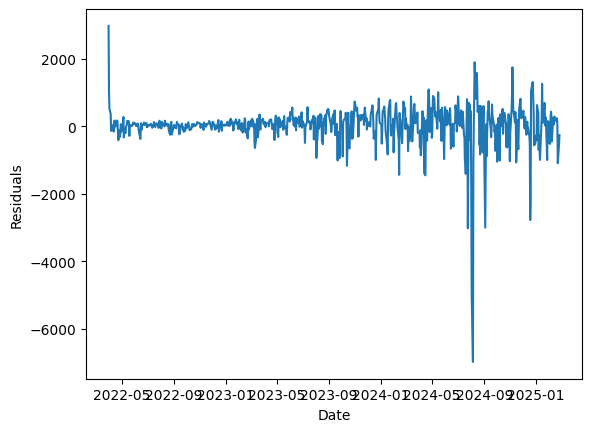

In [29]:
state_means0 = np.array(pd.DataFrame(state_means)[0])
print(state_means0)
resid = Signal['Signal'] - state_means0
stdev = []
for i in range(len(resid)):
    stdev.append(math.sqrt(state_covs[i][0][0]))
plt.plot(resid)
plt.xlabel('Date')
plt.ylabel("Residuals")

# adf_test(resid.dropna())

# H, c,  drop = compute_Hc(resid.dropna())
# print('Hurst Exponent', H)

## Portfolio Optimization

In [30]:
means

array([[ 2968.29856775],
       [ 4488.3407074 ],
       [ 5310.09584984],
       [ 5897.15987857],
       [ 5670.24542165],
       [ 5475.53344492],
       [ 5531.42410288],
       [ 5563.24435179],
       [ 5300.99210316],
       [ 5144.07926915],
       [ 5414.53439451],
       [ 5386.91315302],
       [ 5439.32495556],
       [ 5712.56443622],
       [ 5939.37649219],
       [ 5638.27972694],
       [ 4965.73868319],
       [ 4783.24728944],
       [ 4271.26848752],
       [ 4011.7849649 ],
       [ 4106.13530865],
       [ 3842.22521498],
       [ 3795.28095416],
       [ 3997.39660465],
       [ 4439.29930402],
       [ 3901.35777249],
       [ 3740.45461958],
       [ 3399.89551589],
       [ 3376.84002705],
       [ 3384.99317893],
       [ 3454.39337485],
       [ 3702.65458582],
       [ 3950.41385549],
       [ 4142.68343743],
       [ 3676.03170562],
       [ 3706.27047087],
       [ 3708.34520171],
       [ 3760.46169954],
       [ 3766.59830584],
       [ 3845.06689545],


In [31]:
bounds = {'Mu':0, 'Sigma':0, 'Beta':0, 'Mu_Min':0, 'Sigma_Min':0}
MIP = OptimizationEngine.mipEngine.mipEngine()
# MIP._addVariables(mf_summary.columns, var_bounds=(None,None), var_type="INTEGER")
MIP._addConstraints(mf_summary, bounds, var_bounds=(1,None))
MIP._optimize()
#pd.DataFrame(mf_summary)

optimal solution cost 0.0 found
solution:


In [32]:
raw = raw.reset_index().set_index('timestamp')
raw

,0,VIXY
timestamp,,
2022-03-30 04:00:00,6251.397136,315.80
2022-03-31 04:00:00,5833.102134,331.40
2022-04-01 04:00:00,6143.692814,320.00
2022-04-04 04:00:00,6563.380468,302.80
2022-04-05 04:00:00,5858.371030,328.40
...,...,...
2025-02-19 05:00:00,32185.088205,40.50
2025-02-20 05:00:00,32056.176749,40.73
2025-02-21 05:00:00,29148.543007,43.56


In [33]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
## analysis between adr spread and volume pct
df = signal

df.fillna(method='ffill', inplace=True)
# df['ADR_Vol_Pct'] = df['TSMC34_SA_Volume']/(df['TSMC34_SA_Volume'] +df['TSM_Volume'])
mean = df.mean()
std = df.std()
# df['ADR_Vol_Pct'] = (df['ADR_Vol_Pct'] - mean)/std
# df['ADR_Spread'] = df['TSM_Close'] - df['TSMC34_SA_Close']
# mean = df['ADR_Spread'].mean()
# std = df['ADR_Spread'].std()
# df['ADR_Spread'] = (df['ADR_Spread'] - mean)/std
coint_test_result = coint_johansen(raw, det_order=1, k_ar_diff=0)
tracevalues = coint_test_result.lr1
critical_values = coint_test_result.cvt
for i, (stock1, stock2) in enumerate([list(raw.columns.values)]):
    if (tracevalues[i] > critical_values[:, 1]).all():
        print(f"Pair {i + 1} ({stock1} and {stock2}) is cointegrated.")
    else:
        print(f"Pair {i + 1} ({stock1} and {stock2}) is not cointegrated.")

Pair 1 (0 and VIXY) is not cointegrated.


C:\Users\raymo\AppData\Local\Temp\ipykernel_40360\246132147.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [34]:
np.std(np.array(covs).flatten())/np.array(means).flatten()
# init_mu

array([1.48884976e-06, 9.84629040e-07, 8.32254394e-07, 7.49403220e-07,
       7.79393179e-07, 8.07108686e-07, 7.98953492e-07, 7.94383695e-07,
       8.33683680e-07, 8.59114017e-07, 8.16201409e-07, 8.20386458e-07,
       8.12481446e-07, 7.73619388e-07, 7.44076522e-07, 7.83811875e-07,
       8.89968418e-07, 9.23922669e-07, 1.03466935e-06, 1.10159209e-06,
       1.07627983e-06, 1.15020603e-06, 1.16443306e-06, 1.10555720e-06,
       9.95506340e-07, 1.13277245e-06, 1.18150093e-06, 1.29984895e-06,
       1.30872371e-06, 1.30557149e-06, 1.27934202e-06, 1.19356275e-06,
       1.11870573e-06, 1.06678453e-06, 1.20220688e-06, 1.19239830e-06,
       1.19173118e-06, 1.17521490e-06, 1.17330022e-06, 1.14935597e-06,
       1.13262718e-06, 1.08443158e-06, 1.04911210e-06, 1.02966701e-06,
       1.00332703e-06, 1.00304968e-06, 9.91001751e-07, 9.64104736e-07,
       9.50976490e-07, 9.90787883e-07, 1.06557374e-06, 1.25005876e-06,
       1.29330531e-06, 1.24212202e-06, 1.30056261e-06, 1.28583085e-06,
      

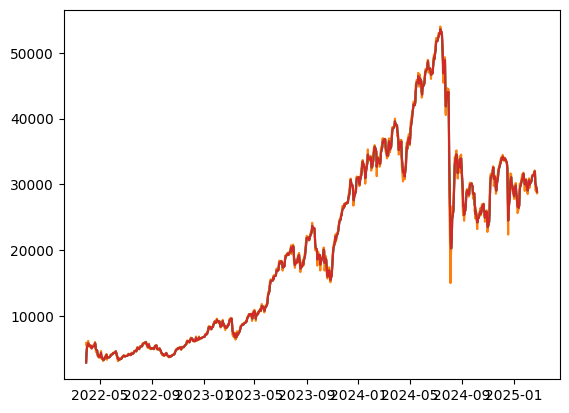

In [35]:
### roll filter over 90 day windows
roll = 0
training_period = datetime.timedelta(days=90)
# testing_period = datetime.timedelta(days=30)
min_time_delta = datetime.timedelta(hours=1)
start_date = Signal.index[0] 
means = []
covs = []
init_mu = 1#np.mean(Signal[start_date:start_date+training_period])
init_cov = 1#np.var(Signal[start_date:start_date+training_period])
start_date += (training_period + min_time_delta)
# while (start_date + training_period < Signal.index[-1]):
#     means_temp, covs_temp = KalmanFilter.KalmanFilter.UnivariateKF('Signal', 
#                 Signal[start_date:start_date+training_period], 
#                 init_mu,
#                 init_cov
#                 )
#     means.extend(means_temp)
#     covs.extend(covs_temp)
#     init_mu = 1#np.mean(Signal[start_date:start_date+training_period])
#     init_cov = 1#np.var(Signal[start_date:start_date+training_period])
#     # print(len(Signal[start_date:start_date+training_period]),len(covs))
#     # print()
#     start_date += (training_period + min_time_delta)
# means_temp, covs_temp = KalmanFilter.KalmanFilter.UnivariateKF('Signal', 
#             Signal[start_date:], 
#             init_mu,
#             init_cov)
# means.extend(means_temp)
# covs.extend(covs_temp)

means, covs = KalmanFilter.KalmanFilter.UnivariateKF('Signal', 
            Signal, 
            init_mu,
            init_cov
            )
# print(len(Signal[start_date:]), len(covs))
plt.plot(Signal.index, np.array(means).flatten())
plt.plot(Signal)
plt.plot(Signal.index, np.array(means).flatten() + np.std(np.array(covs).flatten()))
plt.plot(Signal.index, np.array(means).flatten() - np.std(np.array(covs).flatten()))

In [36]:
means

array([[ 2968.29856775],
       [ 4488.3407074 ],
       [ 5310.09584984],
       [ 5897.15987857],
       [ 5670.24542165],
       [ 5475.53344492],
       [ 5531.42410288],
       [ 5563.24435179],
       [ 5300.99210316],
       [ 5144.07926915],
       [ 5414.53439451],
       [ 5386.91315302],
       [ 5439.32495556],
       [ 5712.56443622],
       [ 5939.37649219],
       [ 5638.27972694],
       [ 4965.73868319],
       [ 4783.24728944],
       [ 4271.26848752],
       [ 4011.7849649 ],
       [ 4106.13530865],
       [ 3842.22521498],
       [ 3795.28095416],
       [ 3997.39660465],
       [ 4439.29930402],
       [ 3901.35777249],
       [ 3740.45461958],
       [ 3399.89551589],
       [ 3376.84002705],
       [ 3384.99317893],
       [ 3454.39337485],
       [ 3702.65458582],
       [ 3950.41385549],
       [ 4142.68343743],
       [ 3676.03170562],
       [ 3706.27047087],
       [ 3708.34520171],
       [ 3760.46169954],
       [ 3766.59830584],
       [ 3845.06689545],


[[ 2968.29856775]
 [ 4488.3407074 ]
 [ 5310.09584984]
 [ 5897.15987857]
 [ 5670.24542165]
 [ 5475.53344492]
 [ 5531.42410288]
 [ 5563.24435179]
 [ 5300.99210316]
 [ 5144.07926915]
 [ 5414.53439451]
 [ 5386.91315302]
 [ 5439.32495556]
 [ 5712.56443622]
 [ 5939.37649219]
 [ 5638.27972694]
 [ 4965.73868319]
 [ 4783.24728944]
 [ 4271.26848752]
 [ 4011.7849649 ]
 [ 4106.13530865]
 [ 3842.22521498]
 [ 3795.28095416]
 [ 3997.39660465]
 [ 4439.29930402]
 [ 3901.35777249]
 [ 3740.45461958]
 [ 3399.89551589]
 [ 3376.84002705]
 [ 3384.99317893]
 [ 3454.39337485]
 [ 3702.65458582]
 [ 3950.41385549]
 [ 4142.68343743]
 [ 3676.03170562]
 [ 3706.27047087]
 [ 3708.34520171]
 [ 3760.46169954]
 [ 3766.59830584]
 [ 3845.06689545]
 [ 3901.8581638 ]
 [ 4075.26920158]
 [ 4212.4674628 ]
 [ 4292.01924357]
 [ 4404.69602638]
 [ 4405.91396257]
 [ 4459.47809475]
 [ 4583.89056545]
 [ 4647.17124694]
 [ 4460.44070591]
 [ 4147.39067858]
 [ 3535.31428596]
 [ 3417.09769765]
 [ 3557.90376554]
 [ 3398.02987342]
 [ 3436.96

Text(0, 0.5, 'Residuals')

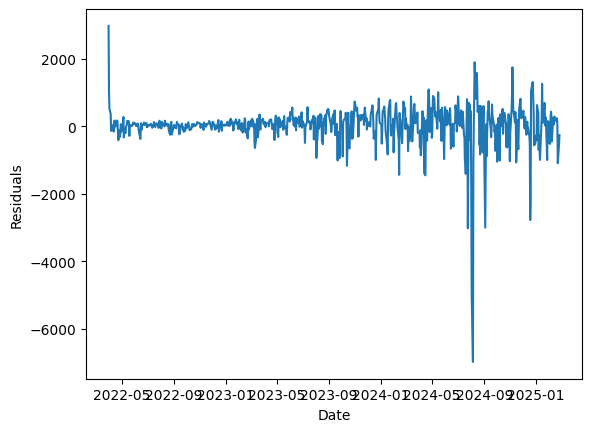

In [37]:
state_means0 = np.array(pd.DataFrame(means.flatten()))
print(means)
resid = Signal['Signal'] - means.flatten()
stdev = []
# for i in range(len(resid)):
#     stdev.append(math.sqrt(covs[0].flatten()[i]))
stdev = covs.flatten()
plt.plot(resid)
plt.xlabel('Date')
plt.ylabel("Residuals")

# adf_test(resid.dropna())

# H, c,  drop = compute_Hc(resid.dropna())
# print('Hurst Exponent', H)

Text(0, 0.5, 'Value')

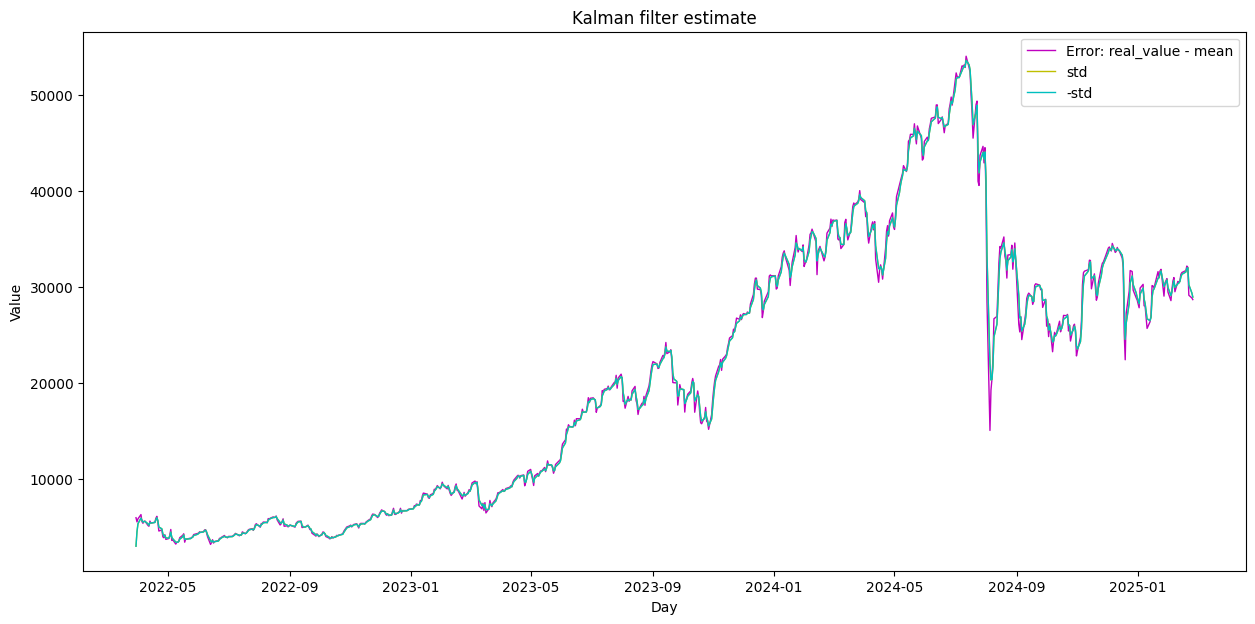

In [38]:
# mean, std = means.squeeze(), np.std(covs.squeeze())

plt.figure(figsize=(15,7))
plt.plot(Signal.index, Signal['Signal'], 'm', lw=1)
plt.plot(Signal.index, np.array(means).squeeze() + 1.5*np.sqrt(covs.flatten()), 'y', lw=1)
plt.plot(Signal.index, np.array(means).squeeze() - 1.5*np.sqrt(covs.flatten()), 'c', lw=1)
plt.title('Kalman filter estimate')
plt.legend(['Error: real_value - mean', 'std', '-std'])
plt.xlabel('Day')
plt.ylabel('Value')

In [39]:
df

timestamp
2022-03-30 04:00:00     5935.597136
2022-03-31 04:00:00     5501.702134
2022-04-01 04:00:00     5823.692814
2022-04-04 04:00:00     6260.580468
2022-04-05 04:00:00     5529.971030
                           ...     
2025-02-19 05:00:00    32144.588205
2025-02-20 05:00:00    32015.446749
2025-02-21 05:00:00    29104.983007
2025-02-24 05:00:00    28832.354955
2025-02-25 05:00:00    28651.348004
Length: 729, dtype: float64

In [40]:
from statsmodels.regression.rolling import RollingOLS

df = pd.DataFrame()
df['primitive_signal'] = Signal['Signal']
df['filter_resid'] = resid
df['filter_spread'] = stdev
df = pd.merge_asof(hf_df, df, on='timestamp')


def simpleFilterSignal(dr, epsilon):
    if dr.filter_resid < -dr.filter_spread*epsilon:
        return -1
    elif dr.filter_resid > dr.filter_spread*epsilon:
        return 1
    else:
        return 0

# means, covs = KalmanFilter.KalmanFilter.UnivariateKF('Signal', Signal, 
#                                                      np.mean(Signal[-252:]),
#                                                      np.var(Signal[-252:]))

df['Signal'] = df.apply(lambda dr: simpleFilterSignal(dr, 1.5), axis=1)
### shift signal back so that it's not forward looking
df['Signal'] = df['Signal'].shift(1)
df['BuySell'] = (df['Signal'] - df['Signal'].shift(1))/2
df = df.reset_index().rename(columns={"timestamp":"Date"})
### rolling coefficient
window = int(60*9.5*21) #21 days
LEGS = list(mf_bucket.keys())
ret_df = logRetDtDailyTransform(df[LEGS])
# df['HedgeRatio'] = ret_
model = RollingOLS(-1*ret_df[reference_ticker], ret_df[[x for x in LEGS if x != reference_ticker]], window=window)
hedge_ratios = model.fit().params.shift(1)
for ticker in LEGS:
    if ticker == reference_ticker:
        df[f'{ticker}_hr'] = -1
    else:
        df[f'{ticker}_hr'] = hedge_ratios[ticker]
df

,index,Date,SVXY,SVIX,VIXY,primitive_signal,filter_resid,filter_spread,Signal,BuySell,SVXY_hr,SVIX_hr,VIXY_hr
0,0,2022-03-30 13:32:00,28.0700,14.88,315.340,5935.597136,2967.298568,0.500000,NaN,NaN,NaN,NaN,-1
1,1,2022-03-30 13:33:00,28.0750,14.89,315.000,5935.597136,2967.298568,0.500000,1.0,NaN,NaN,NaN,-1
2,2,2022-03-30 13:34:00,28.0750,14.89,315.002,5935.597136,2967.298568,0.500000,1.0,0.0,NaN,NaN,-1
3,3,2022-03-30 13:35:00,28.1100,14.89,314.400,5935.597136,2967.298568,0.500000,1.0,0.0,NaN,NaN,-1
4,4,2022-03-30 13:36:00,28.0850,14.90,315.000,5935.597136,2967.298568,0.500000,1.0,0.0,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
283173,283173,2024-12-31 21:53:00,50.0800,25.35,45.130,28620.438564,-284.456671,0.618034,-1.0,0.0,1.062394,0.307389,-1
283174,283174,2024-12-31 22:27:00,50.0300,25.35,45.130,28620.438564,-284.456671,0.618034,-1.0,0.0,1.062380,0.307410,-1
283175,283175,2024-12-31 22:45:00,50.0298,25.35,45.130,28620.438564,-284.456671,0.618034,-1.0,0.0,1.062265,0.307455,-1
283176,283176,2024-12-31 22:55:00,50.0300,25.35,45.130,28620.438564,-284.456671,0.618034,-1.0,0.0,1.062261,0.307457,-1


In [41]:
BBO = order_book.Book()
HOLDING_PERIOD_CHECK = {}
isLong = False
hasPosition = False

def isFirstTrade(ticker, date):
    if ticker not in HOLDING_PERIOD_CHECK:
        return True
    if date not in HOLDING_PERIOD_CHECK[ticker]:
        return True
    return False

pairsLEGS = [x for x in LEGS if x != reference_ticker]

for _, row in df.iloc[window:].iterrows():
    if (row.BuySell == 1 
        and not hasPosition
        and isFirstTrade(reference_ticker, row.Date.normalize())):
        print('bought spread at ', row.Date)
        BBO.addOrder(row.Date, reference_ticker, row[reference_ticker],10 * row[f'{reference_ticker}_hr'])
        for LEG in pairsLEGS:
            BBO.addOrder(row.Date, LEG, row[LEG], -10 * row[f'{LEG}_hr'])
        if reference_ticker not in HOLDING_PERIOD_CHECK:
            HOLDING_PERIOD_CHECK[reference_ticker] = []
        HOLDING_PERIOD_CHECK[reference_ticker].append(row.Date.normalize())
        isLong = True
        hasPosition = True
    elif (row.BuySell == -1 
        and not hasPosition
        and isFirstTrade(reference_ticker, row.Date.normalize())):
        print('sold spread at ', row.Date)
        BBO.addOrder(row.Date, reference_ticker, row[reference_ticker], -10 * row[f'{reference_ticker}_hr'])
        for LEG in pairsLEGS:
            BBO.addOrder(row.Date, LEG, row[LEG], 10 * row[f'{LEG}_hr'])
        isLong = False
        if reference_ticker not in HOLDING_PERIOD_CHECK:
            HOLDING_PERIOD_CHECK[reference_ticker] = []
        HOLDING_PERIOD_CHECK[reference_ticker].append(row.Date.normalize())
        hasPosition = True
        isLong = False
    else:
        if hasPosition and isFirstTrade(reference_ticker, row.Date.normalize()):
            print('exit spread at ', row.Date)
            prices = {}
            for ticker in LEGS:
                prices[ticker] = row[ticker]
            BBO.unwindALL(row.Date, prices =prices)
            if reference_ticker not in HOLDING_PERIOD_CHECK:
                HOLDING_PERIOD_CHECK[reference_ticker] = []
                HOLDING_PERIOD_CHECK[reference_ticker].append(row.Date.normalize())
            hasPosition = False
            isLong = False

#BBO.addOrder(df_res.iloc[100]["Date"], "TSM", 300.0, 10)
#BBO.addOrder(df_res.iloc[120]["Date"], "TSM", 250.0, 25)
#BBO.addOrder(df_res.iloc[200]["Date"], "TSM", 350.0, -30)
#BBO.getTickerBook(["TSLA"]).tail(1)#.loc['Quantity']
#BBO.get_history()

#BBO.addOrder(df_res.iloc[50]["Date"], "TSMC34.SA", 300.0, 10)
#BBO.addOrder(df_res.iloc[150]["Date"], "TSMC34.SA", 250.0, -25)

sold spread at  2022-05-05 08:02:00
exit spread at  2022-05-06 08:08:00
bought spread at  2022-05-11 08:18:00
exit spread at  2022-05-12 08:02:00
sold spread at  2022-05-18 11:25:00
exit spread at  2022-05-19 08:06:00
bought spread at  2022-05-19 08:08:00
exit spread at  2022-05-20 08:00:00
sold spread at  2022-06-09 08:39:00
exit spread at  2022-06-10 08:09:00
bought spread at  2022-06-15 08:05:00
exit spread at  2022-06-16 08:00:00
sold spread at  2022-06-16 08:01:00
exit spread at  2022-06-17 08:03:00
bought spread at  2022-06-17 08:07:00
exit spread at  2022-06-21 08:00:00
sold spread at  2022-06-28 08:18:00
exit spread at  2022-06-29 08:03:00
bought spread at  2022-07-01 08:04:00
exit spread at  2022-07-05 08:05:00
sold spread at  2022-07-11 08:17:00
exit spread at  2022-07-12 08:00:00
bought spread at  2022-07-13 08:37:00
exit spread at  2022-07-14 08:39:00
sold spread at  2022-07-18 08:01:00
exit spread at  2022-07-19 09:22:00
bought spread at  2022-07-19 10:05:00
exit spread at

In [42]:
BBO.get_history()

[{'Date': Timestamp('2022-05-05 08:02:00'),
  'Ticker': 'VIXY',
  'Quantity': 10,
  'CostBasis': 3556.0,
  'Value': 3556.0,
  'PnL': 0.0,
  'Cash': -3556.0},
 {'Date': Timestamp('2022-05-05 08:02:00'),
  'Ticker': 'SVXY',
  'Quantity': 14.741183298815976,
  'CostBasis': 377.44799836618307,
  'Value': 377.44799836618307,
  'PnL': 0.0,
  'Cash': -377.44799836618307},
 {'Date': Timestamp('2022-05-05 08:02:00'),
  'Ticker': 'SVIX',
  'Quantity': 0.9514208045856287,
  'CostBasis': 11.588305399852958,
  'Value': 11.588305399852958,
  'PnL': 0.0,
  'Cash': -11.588305399852958},
 {'Date': Timestamp('2022-05-06 08:08:00'),
  'Ticker': 'SVIX',
  'Quantity': 0.0,
  'CostBasis': 0,
  'Value': 0,
  'PnL': 0,
  'Cash': -1.9789552735381086},
 {'Date': Timestamp('2022-05-06 08:08:00'),
  'Ticker': 'VIXY',
  'Quantity': 0.0,
  'CostBasis': 0,
  'Value': 0,
  'PnL': 0,
  'Cash': 568.0},
 {'Date': Timestamp('2022-05-06 08:08:00'),
  'Ticker': 'SVXY',
  'Quantity': 0.0,
  'CostBasis': 0,
  'Value': 0,
  '

In [43]:
BBO.getOrderDf()

,Date,Ticker,Price,Quantity,Longshort
0,2022-05-05 08:02:00,VIXY,355.600,10.000000,True
1,2022-05-05 08:02:00,SVXY,25.605,14.741183,True
2,2022-05-05 08:02:00,SVIX,12.180,0.951421,True
3,2022-05-06 08:08:00,SVIX,10.100,-0.951421,False
4,2022-05-06 08:08:00,VIXY,412.400,-10.000000,False
...,...,...,...,...,...
1345,2024-12-27 09:05:00,SVXY,51.510,10.630684,True
1346,2024-12-27 09:05:00,SVIX,27.470,3.143002,True
1347,2024-12-30 09:04:00,SVIX,25.410,-3.143002,False
1348,2024-12-30 09:04:00,VIXY,43.800,-10.000000,False


In [44]:

df_res = pd.DataFrame()

for ticker in LEGS:
    df_temp = df[['Date',ticker]].rename(columns={ticker:"Price"})
    df_temp['Ticker'] = ticker
    df_res = pd.concat([df_res, df_temp])

#1.rename(columns={'SVIX':'Price'}),df2.rename(columns={'VIXY':'Price'})])
df_res
#df1.drop('index', inplace=True)
#df_res.rename(columns={'Datetime':'Date'}, inplace=True)
BBO.backfillPnL(df_res)

In [45]:
hist

,Open,High,Low,^FTW5000,Volume,Dividends,Stock Splits
timestamp,,,,,,,
2023-04-18,41036.410156,41222.539062,40922.570312,41059.039062,0,0.0,0.0
2023-04-19,41059.039062,41140.179688,40850.308594,41064.578125,0,0.0,0.0
2023-04-20,41064.578125,41064.578125,40662.539062,40808.878906,0,0.0,0.0
2023-04-21,40808.878906,40890.949219,40639.500000,40845.910156,0,0.0,0.0
2023-04-24,40845.910156,40928.878906,40664.910156,40855.570312,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-04-11,52355.578125,53442.128906,51851.011719,53283.019531,0,0.0,0.0
2025-04-14,53283.019531,54243.378906,53215.109375,53722.269531,0,0.0,0.0
2025-04-15,53722.269531,54185.328125,53536.648438,53652.519531,0,0.0,0.0


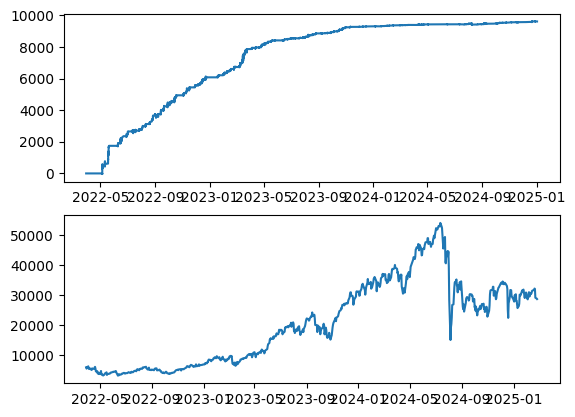

In [46]:
hist = BBO.getHistoryDf()
figure, axis = plt.subplots(2,1)

# For Sine Function
axis[0].plot(hist.index, hist['Value'] + hist['Cash'])
# axis[0, 0].set_title("Sine Function")

# For Cosine Function
axis[1].plot(Signal.index, Signal)
# axis[0, 1].set_title("Cosine Function")
# plt.plot(hist['PnL'])
plt.show()

In [47]:
### Sharpe Ratio and whatnot


### drawdown


In [48]:
BBO.getHistoryDf()

,CostBasis,Value,PnL,Cash
Date,,,,
2022-03-30 13:32:00,0.0,0.0,0.000000,0.000000
2022-03-30 13:33:00,0.0,0.0,0.000000,0.000000
2022-03-30 13:34:00,0.0,0.0,0.000000,0.000000
2022-03-30 13:35:00,0.0,0.0,0.000000,0.000000
2022-03-30 13:36:00,0.0,0.0,0.000000,0.000000
...,...,...,...,...
2024-12-31 21:53:00,0.0,0.0,9618.015468,9618.015468
2024-12-31 22:27:00,0.0,0.0,9618.015468,9618.015468
2024-12-31 22:45:00,0.0,0.0,9618.015468,9618.015468


Sharpe?: 0.001344369541677975


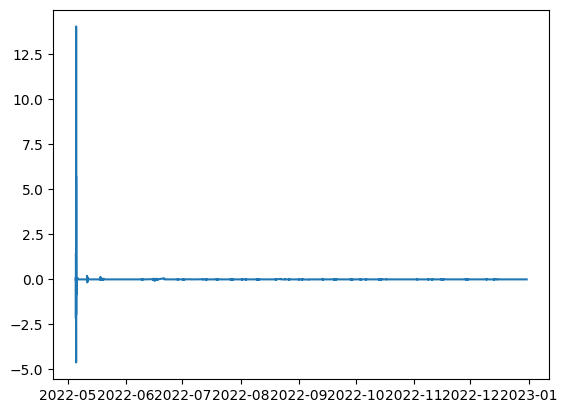

In [77]:
pnl = BBO.getHistoryDf()['2022-05-05':'2023-01-01']
pnl['PortfolioValue'] = pnl['Value'] \
+ pnl['Cash']
pnl['CashChange'] = pnl['Cash'] - pnl['Cash'].shift(1)
pnl['Returns'] = (pnl['PortfolioValue'] - pnl['PortfolioValue'].shift(1))/pnl['PortfolioValue'].shift(1)
plt.plot(pnl['Returns'])
# plt.plot(pnl['PortfolioValue'])
print('Sharpe?: ' + str(pnl['Returns'].dropna()[1:].mean()/pnl['Returns'].dropna()[1:].std()))

In [70]:
pnl.dropna(subset='Returns', axis=0, inplace=True)
math.sqrt(252)*(pnl['Returns'][1:].mean())/(pnl['Returns'][1:].std())

0.011902075255152458

In [71]:
pnl['Returns'].dropna()

Date
2022-05-05 08:40:00             inf
2022-05-05 08:58:00   -3.059993e-02
2022-05-05 09:18:00    9.995849e-02
2022-05-05 09:33:00   -4.419604e-01
2022-05-05 09:55:00    1.114213e-01
                           ...     
2024-12-31 21:53:00    0.000000e+00
2024-12-31 22:27:00   -1.891232e-16
2024-12-31 22:45:00    0.000000e+00
2024-12-31 22:55:00    1.891232e-16
2024-12-31 22:56:00    0.000000e+00
Name: Returns, Length: 271071, dtype: float64